In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
from keras.layers import Activation
import keras.regularizers as reg 
import keras.callbacks as clb
from keras.optimizers import SGD, Adam
from timeit import default_timer as timer
import os
from sklearn.metrics import mean_absolute_error
import copy

# Project imports:
from preprocesing import PreprocessingDenga, PreprocessingSeries
from split_train_test import TruncatedSplitTrainTest
from utils import plot_compare_precictions, \\
                  plot_prog_vs_correct, \\
                  display_error_change_and_avg, \\
                  my_beep

C:\Programy\Anaconda2\envs\deeplearningPy35\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
%matplotlib inline
pd.set_option('display.max_columns', None)

# Load data

In [3]:
folderPath = "./data/"
folderOutPath = "./results/"
pathToDataTest = folderPath+"dengue_features_test.csv"
pathToDataTrain = folderPath+"dengue_features_train.csv"
pathToDataTrainLabel = folderPath+"dengue_labels_train.csv"
pathToDataSubmission = folderPath+"submission_format.csv"
os.listdir(folderPath)

['dengue_features_test.csv',
 'dengue_features_train.csv',
 'dengue_labels_train.csv',
 'submission_format.csv']

In [4]:
data_pd = pd.read_csv(pathToDataTrain)
data_pd_lab = pd.read_csv(pathToDataTrainLabel)

In [5]:
data_pd.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


In [6]:
data_pd_lab = pd.read_csv(pathToDataTrainLabel)
print(data_pd_lab.shape)
data_pd_lab.head()

(1456, 4)


,city,year,weekofyear,total_cases
0,sj,1990,18,4
1,sj,1990,19,5
2,sj,1990,20,4
3,sj,1990,21,3
4,sj,1990,22,6


# Preprocesing and prepare to train:

In [7]:
truncated_backprop_length = 4
train_test_proportion = 0.8

# Main preprocesing
preprocess = PreprocessingDenga(data_X=data_pd, data_y=data_pd_lab, nan_fill_method="mean")
data_X_basic_prepared = preprocess.scaled
print("Shape before ", data_pd.shape, ", and after ", data_X_basic_prepared.shape)

# Split data by city and prepare for truncated backpropagation throgh time 
data_X_city1, data_X_city2 = preprocess.get_split_data_X_by_city(data_X_basic_prepared)
data_X_truncated_city1 = preprocess.get_truncated_data_X(data_X_city1, truncated_backprop_length)
data_X_truncated_city2 = preprocess.get_truncated_data_X(data_X_city2, truncated_backprop_length)
data_y_truncated_city1, data_y_truncated_city2 = preprocess.get_split_and_truncated_data_y_by_city(data_pd_lab, truncated_backprop_length)

# Divide to test and dev set
train_test_splitter = TruncatedSplitTrainTest(truncated_backprop_length, train_test_proportion)
train_X_not_shaped, test_X_not_shaped = train_test_splitter.get_X(data_X_truncated_city1, data_X_truncated_city2, print_stats = True)
train_y_not_norm, test_y_not_norm = train_test_splitter.get_y(data_y_truncated_city1, data_y_truncated_city2, print_stats = True)

# Normalize y
train_y = preprocess.get_normalized_y(train_y_not_norm)
test_y = preprocess.get_normalized_y(test_y_not_norm)

# Prepare data shape
train_X = train_X_not_shaped.reshape((train_X_not_shaped.shape[0], truncated_backprop_length, preprocess.features_count))
test_X = test_X_not_shaped.reshape((test_X_not_shaped.shape[0], truncated_backprop_length, preprocess.features_count))
print('data_X train, test:',train_X.shape, test_X.shape)

Shape before  (1456, 24) , and after  (1456, 22)
X values:
	City1: (746, 88) (187, 88)
	City2: (413, 88) (104, 88)
	C1&C2: (1159, 88) (291, 88)
Y values:
	City1: (746,) (187,)
	City2: (413,) (104,)
	C1&C2: (1159,) (291,)
data_X train, test: (1159, 4, 22) (291, 4, 22)


C:\Programy\Anaconda2\envs\deeplearningPy35\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


# Train the model

Neural network fit ...
Epoch 00241: early stopping

Czas:  88.57752611795877
Koniec


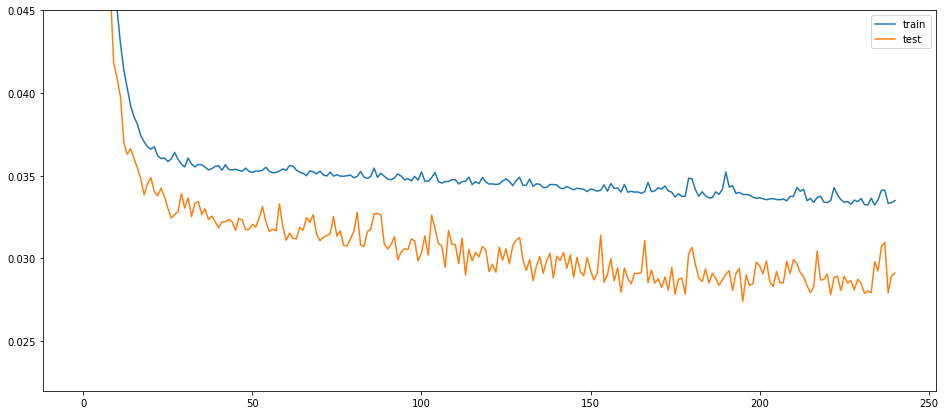

In [73]:
# RNN Architecture:
reg_l2_default = 0.01

batch_size = 64
max_epoch = 1000

drop_out_comon = 0.00
l2_comon = reg.l2(0.003)    #reg.l1_l2(l1 =0.003, l2=0.003)
in_regularizer = l2_comon   #reg.l2(0.1)#None
in_dropout = drop_out_comon #0.04
in_units = 20 #20

l2_regularizer = l2_comon   #reg.l2(0.05)#None
l2_dropout = drop_out_comon #0.01
l2_units = 12

optimizer = Adam() 

verbose = 0
with_early_stopping = True
n_repeats = 1


# Model Definition, with loop for research
model = None
history = None
all_history = []
for n_rep in range(n_repeats): 
    model = Sequential()
    model.add(LSTM(in_units, input_shape=(train_X.shape[1], train_X.shape[2]),
                   return_sequences=True, recurrent_regularizer= in_regularizer, dropout=in_dropout))
    model.add(Activation('elu'))
    model.add(LSTM(l2_units,recurrent_regularizer= l2_regularizer, dropout=l2_dropout))
    model.add(Activation('softmax'))
    model.add(Dense(1))#,activation='relu'))
    model.compile(loss='mae', optimizer=optimizer)#'sgd','adam')# metrics=['accuracy'])


    # Fit network
    print('Neural network fit ...')
    startTime = timer()
    if with_early_stopping:
        callbacks = [clb.EarlyStopping(min_delta=0.0,patience=45,verbose=2)]
    else:
        callbacks = None
    history = model.fit(train_X, train_y, epochs=max_epoch, batch_size=batch_size,
                        validation_data=(test_X, test_y), verbose=verbose, shuffle=True, callbacks=callbacks)
    all_history.append(history.history['val_loss'])
    endTime = timer()
    print('\nTime: ',endTime - startTime)
my_beep()

# plot history
plt.figure(figsize=(16,7))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.ylim(ymin=0.022,ymax=0.045)
plt.legend()

#Show and save statistics
now_str = datetime.now().strftime('%Y.%m.%d.%H.%M')
result_png_path = folderOutPath + "result."+now_str+".png"
plt.savefig(result_png_path)

all_history_np = np.array(all_history)
file_name_np = folderOutPath +"history"+now_str+".npy"
np.save(file_name_np, all_history_np) # .npy extension is added if not given

print('End')

In [36]:
now_str

'2018.01.02.22.05'

In [ ]:
# Plot last history
plt.figure(figsize=(16,7))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.ylim(ymin=0.022,ymax=0.045)
plt.legend()
now_str = datetime.now().strftime('%Y.%m.%d.%H.%M')
result_png_path = folderOutPath + "result."+now_str+".png"
plt.savefig(result_png_path)
#plt.show()

In [22]:
np.array(all_history).shape

(7, 450)

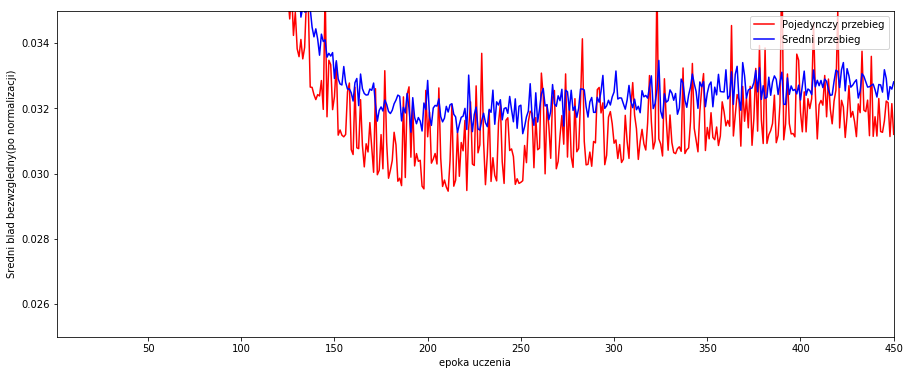

In [41]:
all_hist_to_disp = copy.copy(all_history)
plt.figure(figsize=(15,6))
display_error_change_and_avg(all_history,iteration_cout=np.array(all_history).shape[1])

In [71]:
def print_iterations(x,all_y, x_label,y_label):
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    it = 1
    for chart in all_y:
        chart = np.array(chart)
        x_wyk = x   #[np.negative(np.isnan(chart))]
        wyk = chart #[np.negative(np.isnan(chart))]
        marker = 'D' if it > 5 else 'o'
        plt.plot(x_wyk, wyk, marker=marker, label='Series {}'.format(it))
        it+= 1
    legend =plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

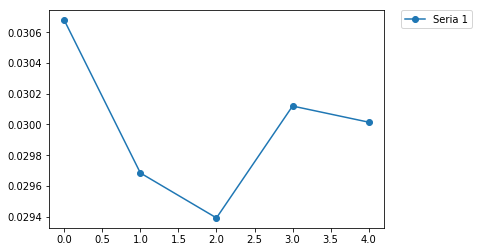

In [75]:
# Show values in a few exaluations. 
all_history_np = np.array(all_history)
only_last_loss = all_history_np[:,-1]
to_disp = [np.average(all_history_np, axis=0)]
#np.repeat(np.arange(5),n_repeats)
print_iterations(range(5),[only_last_loss],'','')

In [21]:
history.history

{'loss': [2.4666486116429103,
  1.9206233762952283,
  1.5319397284497851,
  1.2259704596443572,
  0.9856201245298023,
  0.79585813527288729,
  0.64481801289588114,
  0.52400202188112333,
  0.42719603719183319,
  0.34995485321460712,
  0.28759883627759542,
  0.23769554475187019,
  0.19758558819863212,
  0.16552210282083202,
  0.1396976533542455,
  0.11901273730510659,
  0.10232506153595901,
  0.08906256471950702,
  0.078525898907217603,
  0.069825912403606624,
  0.062961843767071271,
  0.057633403224619205,
  0.053100530780001085,
  0.049626799822369248,
  0.046900967451837236,
  0.044848319619997148,
  0.04294080387117747,
  0.041454844769722041,
  0.041142475114535913,
  0.039560182915942481,
  0.038977324137638186,
  0.038388187510435143,
  0.037710749702109185,
  0.037359641510413183,
  0.037240065054188136,
  0.03669376563197034,
  0.03669370204906356,
  0.036412198212526246,
  0.036225972013954062,
  0.03624703766049811,
  0.036029356419008909,
  0.036067395464591298,
  0.03589412

## Local testing:

In [74]:
y_pred_test_normalized = model.predict(test_X)
y_pred_test = preprocess.get_inverse_y(y_pred_test_normalized)

#print(y_pred_test,test_y);
#for y_pred, y_correct in zip(y_pred_test,test_y):
#    print(y_correct,'->',y_pred, ', DIFF= ',y_correct - y_pred)

In [75]:
mae_test = mean_absolute_error(test_y, y_pred_test_normalized)
print('Test Mean Absolute Error: %.5f' % mae_test)

Test Mean Absolute Error: 0.02911


## Train testing: 

In [76]:
y_pred_train_normalized = model.predict(train_X)
y_pred_train = preprocess.get_inverse_y(y_pred_train_normalized)

#print(y_pred_train,test_y);
#for y_pred, y_correct in zip(y_pred_train,train_y):
#    print(y_correct,'->',y_pred, ', DIFF= ',y_correct - y_pred)

In [77]:
mae_test = mean_absolute_error(train_y, y_pred_train_normalized)
print('Train Mean Absolute Error: %.5f' % mae_test)

Train Mean Absolute Error: 0.03311


# Predict on the competition test set 
(independet results)

In [78]:
# Features X:
print("$$$  Test on competition data: $$$")
data_comp_X_raw = pd.read_csv(pathToDataTest)
# Apply preprocesing and divide data by city
data_comp_X_scaled = preprocess.basic_X_preprocessing(data_comp_X_raw)
data_comp_X_city1_no_past_hist, data_comp_X_city2_no_past_hist = preprocess.get_splited_data_X_by_city(data_comp_X_scaled)

# Append last data from training (competition data starts straight after the training data):
last_obesvation_trom_training_city1 = data_X_city1[-(truncated_backprop_length-1):,:]
last_obesvation_trom_training_city2 = data_X_city2[-(truncated_backprop_length-1):,:]
data_comp_X_city1 = np.concatenate((data_comp_X_city1_no_past_hist,last_obesvation_trom_training_city1))
data_comp_X_city2 = np.concatenate((data_comp_X_city2_no_past_hist,last_obesvation_trom_training_city2))

# Prepare it for backpropagation through time
data_comp_X_truncated_city1 = preprocess.get_truncated_data_X(data_comp_X_city1, truncated_backprop_length)
data_comp_X_truncated_city2 = preprocess.get_truncated_data_X(data_comp_X_city2, truncated_backprop_length)
data_comp_X_not_shaped = np.concatenate((data_comp_X_truncated_city1.values,data_comp_X_truncated_city2.values))
data_comp_X = data_comp_X_not_shaped.reshape((data_comp_X_not_shaped.shape[0],
                                              truncated_backprop_length, preprocess.features_count))

# Prediction:
y_predict_independent = model.predict(data_comp_X)
y_predict_independent = preprocess.get_inverse_y(y_predict_independent)
y_predict_independent = y_predict_independent.astype(int).reshape(-1)
print(type(y_predict_independent),y_predict_independent.shape)
print(y_predict_independent)

# Save prediction for submit it
pd_end_y = pd.read_csv(pathToDataSubmission)
print(pd_end_y.shape,y_predict_independent.shape)
pd_end_y['total_cases'] = y_predict_independent
now_str = datetime.now().strftime('%Y.%m.%d.%H.%M')
resultPath = folderOutPath + "result"+now_str+".csv"
pd_end_y.to_csv(path_or_buf=resultPath, index=False)

$$$  Test on competition data: $$$
Index =  260
(260, 22) (156, 22)
(260, 88)
(156, 88)
<class 'numpy.ndarray'> (416,)
[12 11 13 16 18 19 19 19 19 17 17 24 28 33 35 42 44 49 55 54 39 40 42 43 41
 38 39 35 28 24 20 15 24 26 27 33 21 31 31 24 21 16 16 13 11 10  5  6  9  8
  9 10 11 13 13 13 16 19 21 20 18 21 25 25 26 30 32 38 40 41 41 47 54 58 60
 58 50 37 38 33 33 41 41 37 39 46 42 44 40 32 34 28 26 31 31 31 25 18  8  6
  6 11 13 17 15 12 15 20 20 22 16 13 19 19 22 25 29 28 30 37 37 39 43 45 39
 47 51 52 44 29 27 27 20 12  9 14 18 20 27 28 26 23 14 15 16 15 10  7  5  5
  7 10 10  9  6  6  7  9 12 17 15 17 18 20 19 24 24 23 26 26 26 28 31 37 35
 42 41 34 33 33 34 31 28 31 28 20 24 21 23 33 28 26 22 19 19 18 13 11 12  8
 13 13 14 20 20 16 16 13 14 17 13 13 11 12 16 22 23 25 25 28 30 29 34 36 37
 37 34 37 46 49 50 51 51 55 54 53 50 42 33 25 25 22 22 20 23 20 21 21 14 15
 16 16 16 10 12 13 10  9  8  6  3  3  3  2  1  1  1  2  2  2  3  0  0  0  0
  3  3  4  2  2  6  7  7  4  2  3  6  4  6  5

In [16]:
pd_end_y.head()

,city,year,weekofyear,total_cases
0,sj,2008,18,12
1,sj,2008,19,10
2,sj,2008,20,11
3,sj,2008,21,11
4,sj,2008,22,14


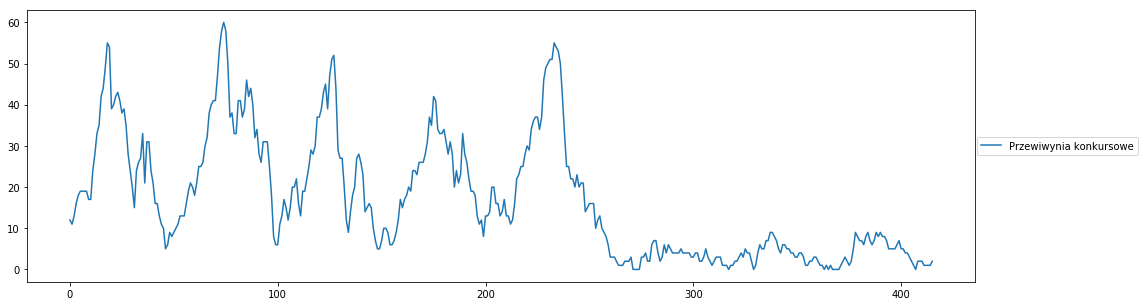

In [79]:
plt.figure(figsize=(17, 5))
plt.plot( y_predict_independent, label='Przewiwynia konkursowe')
plt.legend(bbox_to_anchor=(1.002, 0.5), loc="center left", borderaxespad=0)
plt.show()

# Some result charts:

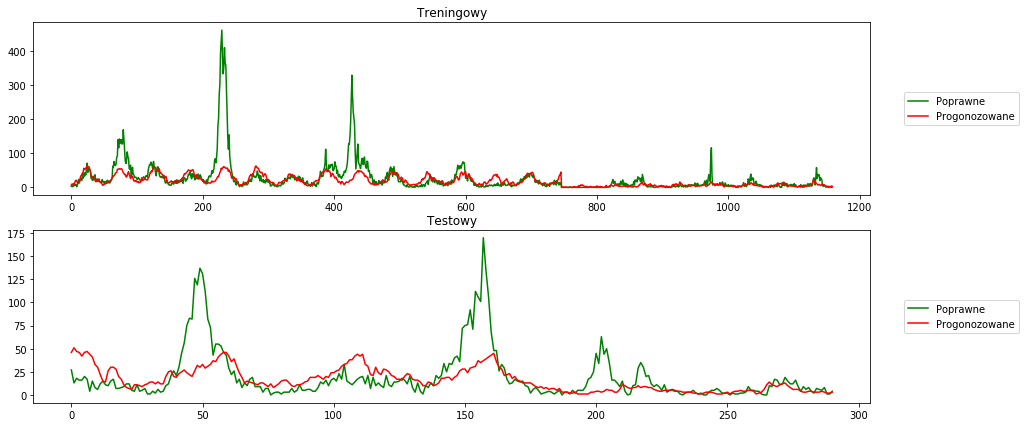

In [80]:
plot_compare_precictions(train_y_not_norm, y_pred_train, test_y_not_norm, y_pred_test)

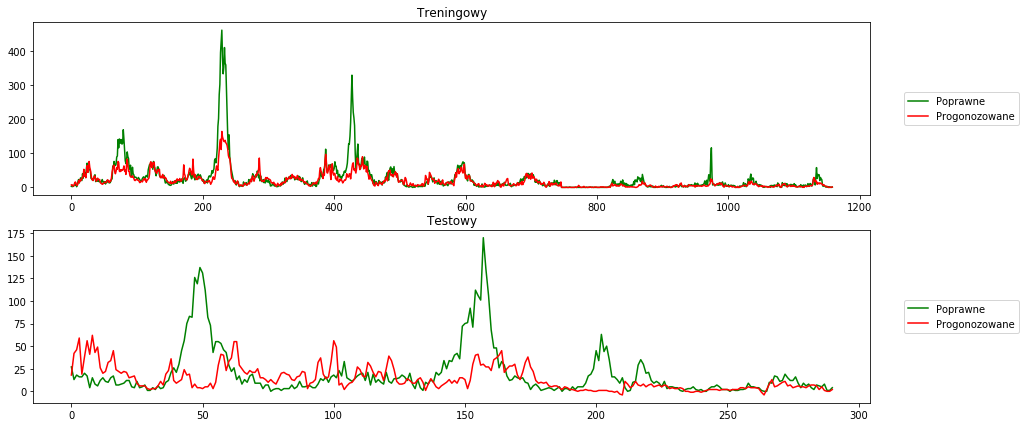

In [108]:
plot_compare_precictions(train_y_not_norm, y_pred_train, test_y_not_norm, y_pred_test)

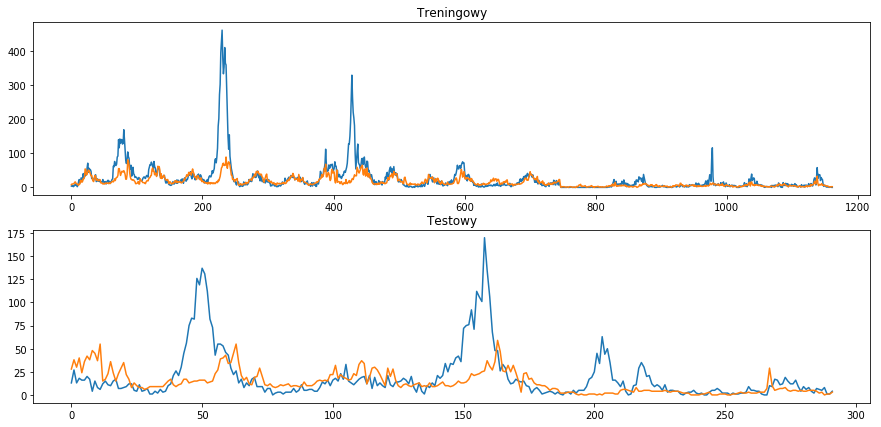

In [44]:
plot_compare_precictions(train_y_not_norm, y_pred_train, test_y_not_norm, y_pred_test)

2017.12.11.09.37


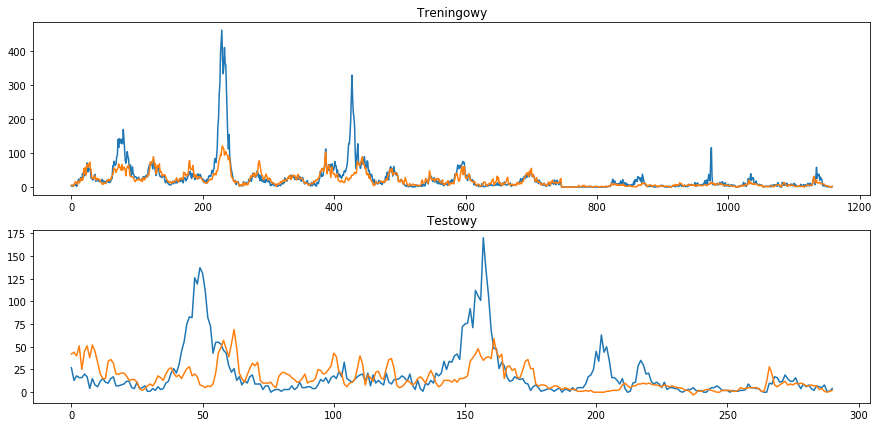

In [16]:
print(now_str)
plot_compare_precictions(train_y_not_norm, y_pred_train, test_y_not_norm, y_pred_test)

# Plot submitted results:

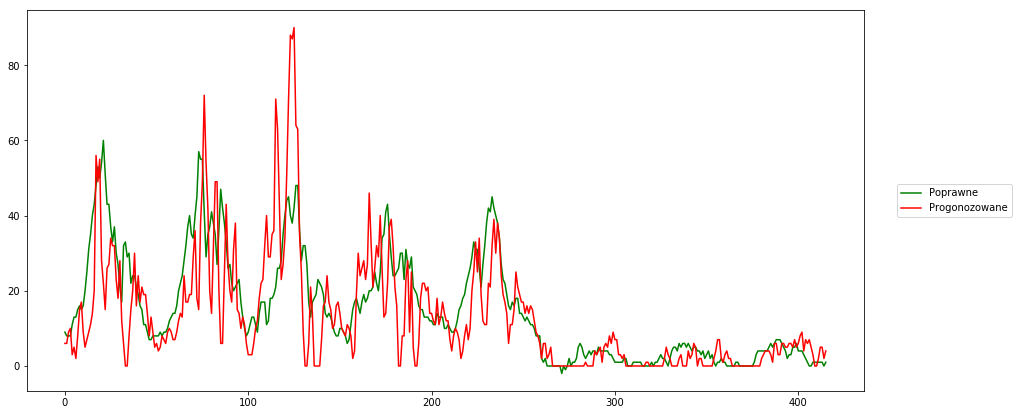

In [30]:
plt.figure(figsize=(15, 7))
os.listdir(folderOutPath)
sub3 = pd.read_csv(folderOutPath+'submission_3_result2017.12.16.22.26.csv')
sub2 = pd.read_csv(folderOutPath+'submission_2_result.csv')
plot_prog_vs_correct(sub2["total_cases"],sub3["total_cases"])